<a href="https://colab.research.google.com/github/Ldj-git/e-commerce_prj/blob/master/e_commerce_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드
- 구글 드라이브에서 압축된 데이터셋을 받아 압축을 풀고 webp같은 지원하지 않는 확장자는 지웁니다.

In [1]:
! gdown https://drive.google.com/uc?id=1mQV9DDmNQR99aLnvjosqgkwXXn_q1bjU

Downloading...
From: https://drive.google.com/uc?id=1mQV9DDmNQR99aLnvjosqgkwXXn_q1bjU
To: /content/food_img.zip
100% 45.4M/45.4M [00:00<00:00, 54.8MB/s]


In [2]:
!unzip -qq '/content/food_img.zip'

In [3]:
!mkdir food_img_data

In [4]:
!mv ./감자 ./food_img_data
!mv ./김치 ./food_img_data
!mv ./대파 ./food_img_data

In [5]:
from pathlib import Path
import imghdr
import os

data_dir = "/content/food_img_data"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

# 학습, 검증 데이터 분류, 배치 사이즈 할당

In [6]:
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
import pathlib

data_dir = pathlib.Path("/content/food_img_data")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

424


In [8]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 424 files belonging to 3 classes.
Using 340 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 424 files belonging to 3 classes.
Using 84 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['감자', '김치', '대파']


# 데이터 표준화, 성능을 높이도록 데이터세트 구성

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# CNN 학습
- 이게 제일 정확도 높긴하네요.
- 모델 용량도 60mb정도로 작고

In [34]:
num_classes = 3

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 2s 87ms/step - loss: 1.6360 - accuracy: 0.4853 - val_loss: 0.8316 - val_accuracy: 0.6429
Epoch 2/15
11/11 [==============================] - 1s 51ms/step - loss: 0.5718 - accuracy: 0.7500 - val_loss: 0.5543 - val_accuracy: 0.7024
Epoch 3/15
11/11 [==============================] - 1s 51ms/step - loss: 0.3156 - accuracy: 0.8618 - val_loss: 0.4059 - val_accuracy: 0.8571
Epoch 4/15
11/11 [==============================] - 1s 51ms/step - loss: 0.2298 - accuracy: 0.9235 - val_loss: 0.2523 - val_accuracy: 0.8929
Epoch 5/15
11/11 [==============================] - 1s 50ms/step - loss: 0.1654 - accuracy: 0.9294 - val_loss: 0.1770 - val_accuracy: 0.9286
Epoch 6/15
11/11 [==============================] - 1s 49ms/step - loss: 0.1151 - accuracy: 0.9500 - val_loss: 0.1554 - val_accuracy: 0.9405
Epoch 7/15
11/11 [==============================] - 1s 50ms/step - loss: 0.1257 - accuracy: 0.9412 - val_loss: 0.1418 - val_accuracy: 0.9405
Epoch 8/15
11

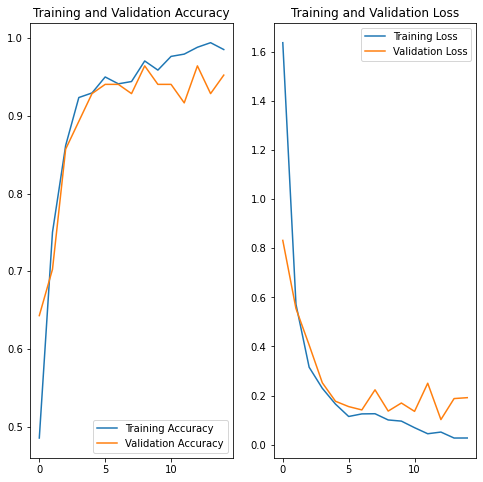

In [36]:
def graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # epochs_range =  history.epochs-history.initial_epoch #range(epochs)
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

import matplotlib.pyplot as plt
graph(history)

In [37]:
test_url = "https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMjAzMDhfMjA0%2FMDAxNjQ2NzM4OTQyNjIx.uZiwjFdpDEk8YkU5M8HuE6FNOzgBRZYczsoGd8BjSjog.in4j-r_AibQhORGmTrHgDM7dMQLqbB7xjfEQapb1vLQg.JPEG.swh21004%2F%25B0%25A8%25C0%25DA5_20220307_205027822_09.jpg&type=sc960_832"
test_path = tf.keras.utils.get_file('1', origin=test_url)

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 154ms/step
This image most likely belongs to 감자 with a 99.99 percent confidence.


# ResNet 학습
- residual block인가? 그거 쓰는 ResNet이라는 모델입니다.
- 파라미터가 많아서 모델 용량이 600mb 정도 됩니다.

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

# 1번방법
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.RandomCrop(height=224, width=224)
    ]
)

# Create a model that includes the augmentation stage
input_shape = (224, 224, 3)
classes = 3
inputs = keras.Input(shape=input_shape)
# Augment images
x = data_augmentation(inputs)
# Rescale image values to [0, 1]
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
# Add the rest of the model
outputs = keras.applications.ResNet152V2(
    weights=None, input_shape=input_shape, classes=classes, classifier_activation='softmax'
)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 3)                 58337795  
                                                                 
Total params: 58,337,795
Trainable params: 58,194,051
Non-trainable params: 143,744
_________________________________________________________________


In [26]:
epochs=10
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 31s 1s/step - loss: 0.9104 - accuracy: 0.6735 - val_loss: 244583.5469 - val_accuracy: 0.2143
Epoch 2/10
11/11 [==============================] - 8s 746ms/step - loss: 0.3925 - accuracy: 0.8559 - val_loss: 39648.4688 - val_accuracy: 0.2143
Epoch 3/10
11/11 [==============================] - 8s 752ms/step - loss: 0.3573 - accuracy: 0.8971 - val_loss: 3999.1570 - val_accuracy: 0.2143
Epoch 4/10
11/11 [==============================] - 8s 753ms/step - loss: 0.2134 - accuracy: 0.9588 - val_loss: 52.9206 - val_accuracy: 0.2143
Epoch 5/10
11/11 [==============================] - 8s 758ms/step - loss: 0.1610 - accuracy: 0.9353 - val_loss: 30.2148 - val_accuracy: 0.2857
Epoch 6/10
11/11 [==============================] - 8s 765ms/step - loss: 0.2051 - accuracy: 0.9471 - val_loss: 1.9506 - val_accuracy: 0.5238
Epoch 7/10
11/11 [==============================] - 9s 778ms/step - loss: 0.1515 - accuracy: 0.9529 - val_loss: 2.2110 - val_accuracy: 0

In [27]:
def graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # epochs_range =  history.epochs-history.initial_epoch #range(epochs)
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

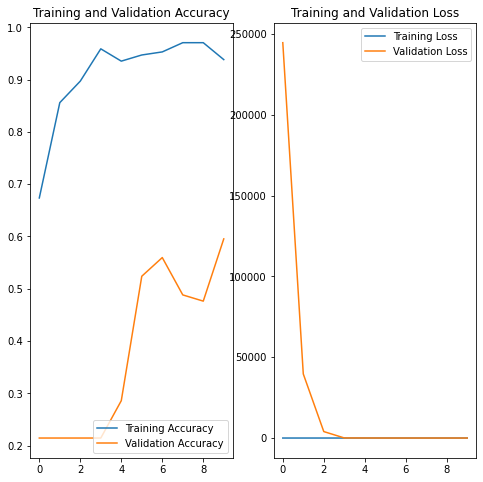

In [28]:
import matplotlib.pyplot as plt
graph(history)

In [29]:
test_url = "https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMjAzMDhfMjA0%2FMDAxNjQ2NzM4OTQyNjIx.uZiwjFdpDEk8YkU5M8HuE6FNOzgBRZYczsoGd8BjSjog.in4j-r_AibQhORGmTrHgDM7dMQLqbB7xjfEQapb1vLQg.JPEG.swh21004%2F%25B0%25A8%25C0%25DA5_20220307_205027822_09.jpg&type=sc960_832"
test_path = tf.keras.utils.get_file('1', origin=test_url)

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to 감자 with a 57.60 percent confidence.


# MobileNet 학습
- 파라미터수가 적고 빠른 모델입니다.
- 최종 용량도 더 작아서 이걸로도 해볼게요.
- 정확도가 구리긴한데 좀 조정해가면서 해봐야할거 같아요

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

# 1번방법
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.RandomCrop(height=224, width=224)
    ]
)

# Create a model that includes the augmentation stage
input_shape = (224, 224, 3)
classes = 3
inputs = keras.Input(shape=input_shape)
# Augment images
x = data_augmentation(inputs)
# Rescale image values to [0, 1]
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
# Add the rest of the model
outputs = keras.applications.MobileNetV2(
    weights=None, input_shape=input_shape, classes=classes, classifier_activation='softmax'
)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 3)                2261827   
 ional)                                                          
                                                                 
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [31]:
epochs=20
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
11/11 [==============================] - 9s 309ms/step - loss: 1.1349 - accuracy: 0.5441 - val_loss: 1.0953 - val_accuracy: 0.3095
Epoch 2/20
11/11 [==============================] - 3s 238ms/step - loss: 0.5888 - accuracy: 0.7618 - val_loss: 1.0938 - val_accuracy: 0.4762
Epoch 3/20
11/11 [==============================] - 3s 252ms/step - loss: 0.3881 - accuracy: 0.8529 - val_loss: 1.0867 - val_accuracy: 0.4762
Epoch 4/20
11/11 [==============================] - 3s 238ms/step - loss: 0.2901 - accuracy: 0.8853 - val_loss: 1.0844 - val_accuracy: 0.4762
Epoch 5/20
11/11 [==============================] - 3s 235ms/step - loss: 0.2086 - accuracy: 0.9088 - val_loss: 1.0733 - val_accuracy: 0.4762
Epoch 6/20
11/11 [==============================] - 3s 233ms/step - loss: 0.2325 - accuracy: 0.9118 - val_loss: 1.0723 - val_accuracy: 0.4762
Epoch 7/20
11/11 [==============================] - 3s 234ms/step - loss: 0.2034 - accuracy: 0.9324 - val_loss: 1.0655 - val_accuracy: 0.4762
Epoch 

In [32]:
def graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # epochs_range =  history.epochs-history.initial_epoch #range(epochs)
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

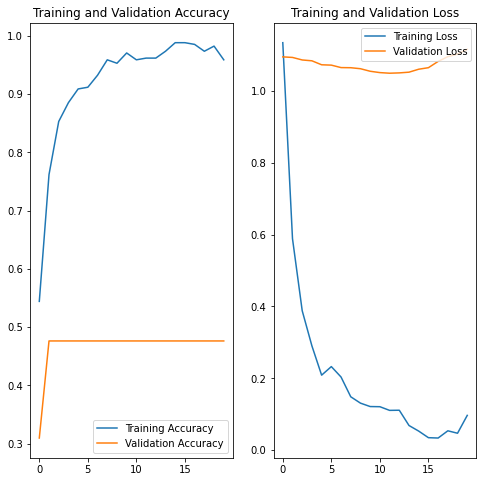

In [33]:
import matplotlib.pyplot as plt
graph(history)

In [24]:
test_url = "https://search.pstatic.net/common/?src=http%3A%2F%2Fblogfiles.naver.net%2FMjAyMjAzMDhfMjA0%2FMDAxNjQ2NzM4OTQyNjIx.uZiwjFdpDEk8YkU5M8HuE6FNOzgBRZYczsoGd8BjSjog.in4j-r_AibQhORGmTrHgDM7dMQLqbB7xjfEQapb1vLQg.JPEG.swh21004%2F%25B0%25A8%25C0%25DA5_20220307_205027822_09.jpg&type=sc960_832"
test_path = tf.keras.utils.get_file('1', origin=test_url)

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 682ms/step
This image most likely belongs to 감자 with a 40.17 percent confidence.


# 모델 저장
- 가장 테스트 정확도가 높은 잘나온 모델을 저장합니다.
- 모델 이름은 구분하기 쉽게 해주세요. (ex-resnet_작업 일시)

In [38]:
 model.save("CNN_11_09")

In [39]:
!zip -r /content/model.zip /content/CNN_11_09

  adding: content/CNN_11_09/ (stored 0%)
  adding: content/CNN_11_09/assets/ (stored 0%)
  adding: content/CNN_11_09/keras_metadata.pb (deflated 92%)
  adding: content/CNN_11_09/variables/ (stored 0%)
  adding: content/CNN_11_09/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: content/CNN_11_09/variables/variables.index (deflated 66%)
  adding: content/CNN_11_09/saved_model.pb (deflated 89%)


# 저장한 모델 드라이브로 옮기기
- 본인 구글 드라이브 마운트 해서 원하는 경로에 저장해두면 됩니다.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
!cp model.zip /content/drive/MyDrive/model.zip